In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from copy import deepcopy

## Cel
Celem ćwiczenia, jest predykcja przyszłych wypożyczeń rowerów na podstawie danych historycznych (2011-2012). W tych danych jednak brakuje warości, która określa wypożyczoną liczbę rowerów (od 20 dnia danego miesiąca do jego końca). Celem będzie predykcja tych wartości. Kiedy te wartości zostaną zalezione, wykonam predykcję szeregu czasowego na podstawie zmiennej *counts* (liczba rowerów wypożyczoych w danej godzinie).

## Analiza danych
### Objaśnienie zmiennych
- datetime - godzina oraz data
- season -  1 = wiosna, 2 = lato, 3 = jesień, 4 = zima 
- holiday - święto (1) lub nie (0)
- workingday - określa czy dzień jest dniem roboczym (1) lub nie (0)
- weather 

1: przejrzyście, lekkie/częsciowe zachmurzenie

2: mgła + zachmurzenie, mgła + "połamane" chmury, mgła + lekkie zachmurzenie, Mgła

3: Lekki śnieg, Lekki deszcz + Burza + Rozproszone chmury, Lekki deszcz + Rozproszone chmury

4: Ulewny deszcz + granulki lodu + burza z piorunami + zamglenue, śnieg + mgła
- temp - temperatura w stopnach Celsiusa
- atemp - odczuwalna temperatura w stopnach Celsiusa
- humidity - wilgotność względna
- windspeed - prekość wiatru
- casual - liczba wypożyczonych rowerów przez użytkowników niezarejestrowanych
- registered - liczba wypożyczonych rowerów przez użytkowników zarejestrowanych
- count - liczba wszystkich wypożyczonych rowerów (casual + registered)

In [2]:
train_original = pd.read_csv("dataset/train.csv", parse_dates=["datetime"])
missing_original = pd.read_csv("dataset/test.csv", parse_dates=["datetime"])

In [3]:
train_extended = deepcopy(train_original)
train_extended["year"] = train_original["datetime"].dt.year
train_extended["month"] = train_original["datetime"].dt.month
train_extended["day"] = train_original["datetime"].dt.day
train_extended["hour"] = train_original["datetime"].dt.hour

### Podstawowe statystyki datasetu

In [4]:
print(train_extended.info(), missing_original.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
 12  year        10886 non-null  int64         
 13  month       10886 non-null  int64         
 14  day         10886 non-null  int64         
 15  hour        10886 non-null  int64         
dtypes: datetime64[ns](1), 

In [5]:
train_extended.nunique()

datetime      10886
season            4
holiday           2
workingday        2
weather           4
temp             49
atemp            60
humidity         89
windspeed        28
casual          309
registered      731
count           822
year              2
month            12
day              19
hour             24
dtype: int64

In [34]:
train_extended

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,2011,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,2012,12,19,19
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,2012,12,19,20
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,2012,12,19,21
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,2012,12,19,22


In [6]:
train_extended.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,2011.501929,6.521495,9.992559,11.541613
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,0.500019,3.444373,5.476608,6.915838
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,2011.000000,1.000000,1.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,2011.000000,4.000000,5.000000,6.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,2012.000000,7.000000,10.000000,12.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,2012.000000,10.000000,15.000000,18.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,2012.000000,12.000000,19.000000,23.000000


In [7]:
missing_original.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000
mean,2.493300,0.029108,0.685815,1.436778,20.620607,24.012865,64.125212,12.631157
std,1.091258,0.168123,0.464226,0.648390,8.059583,8.782741,19.293391,8.250151
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,16.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,49.000000,7.001500
50%,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,65.000000,11.001400
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,81.000000,16.997900
max,4.000000,1.000000,1.000000,4.000000,40.180000,50.000000,100.000000,55.998600


Wniosek: Nie brakuje daych w kolumnach
### Badanie zmiennych czasowych

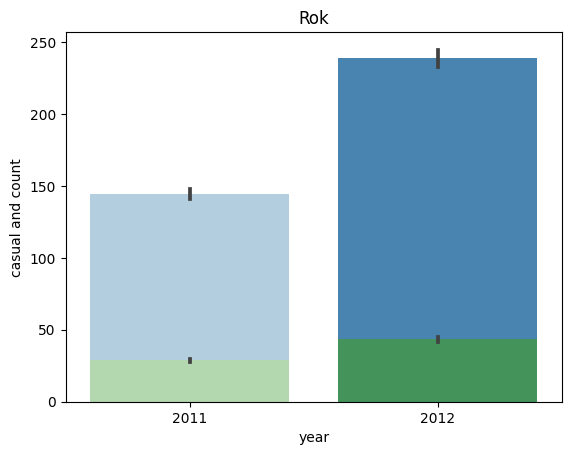

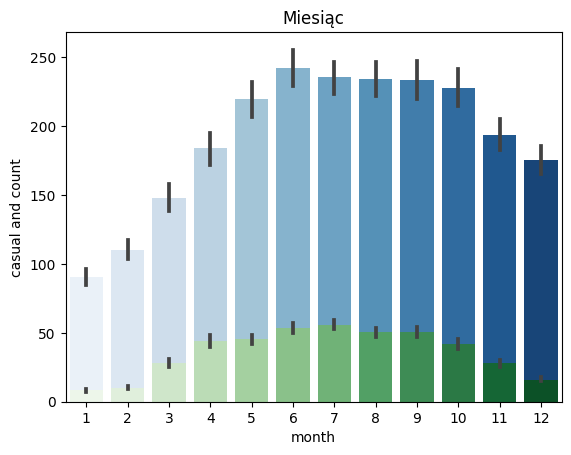

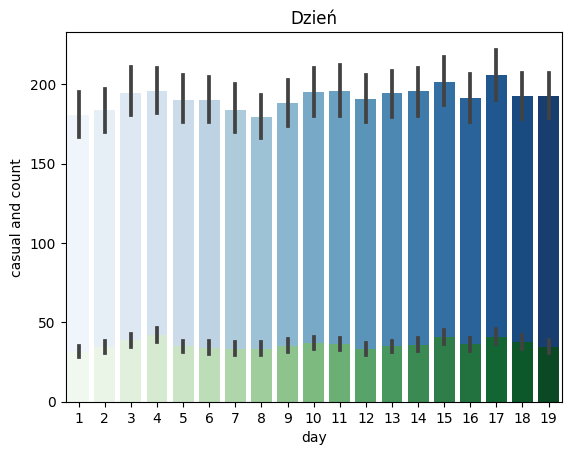

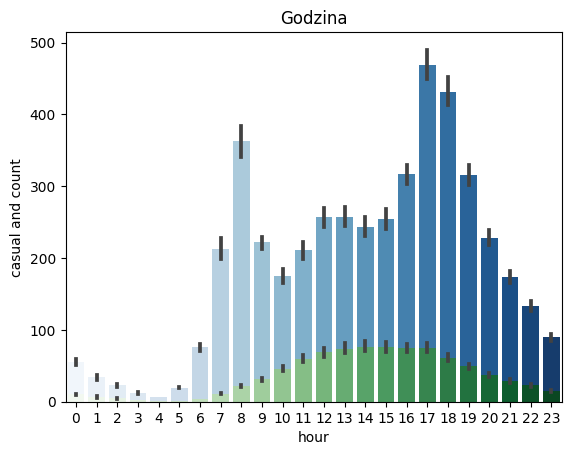

In [31]:
plt.title("Rok")
sb.barplot(x=train_extended["year"], y=train_extended["count"], palette="Blues")
sb.barplot(x=train_extended["year"], y=train_extended["casual"], palette="Greens")
plt.ylabel("casual and count")
plt.show()
plt.title("Miesiąc")
sb.barplot(x=train_extended["month"], y=train_extended["count"], palette="Blues")
sb.barplot(x=train_extended["month"],  y=train_extended["casual"], palette="Greens")
plt.ylabel("casual and count")
plt.show()
plt.title("Dzień")
sb.barplot(x=train_extended["day"], y=train_extended["count"], palette="Blues")
sb.barplot(x=train_extended["day"],  y=train_extended["casual"], palette="Greens")
plt.ylabel("casual and count")
plt.show()
plt.title("Godzina")
sb.barplot(x=train_extended["hour"], y=train_extended["count"], palette="Blues")
sb.barplot(x=train_extended["hour"],  y=train_extended["casual"], palette="Greens")
plt.ylabel("casual and count")
plt.show()

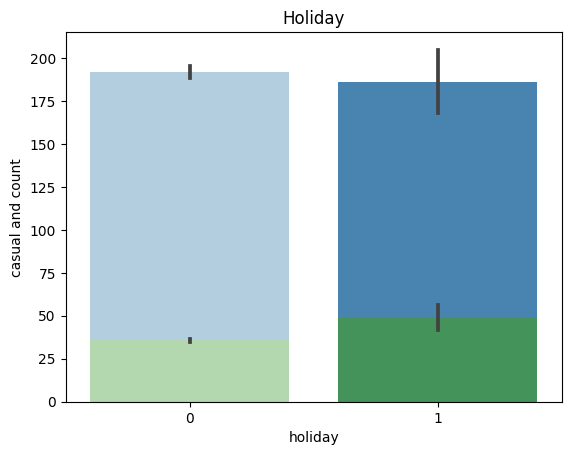

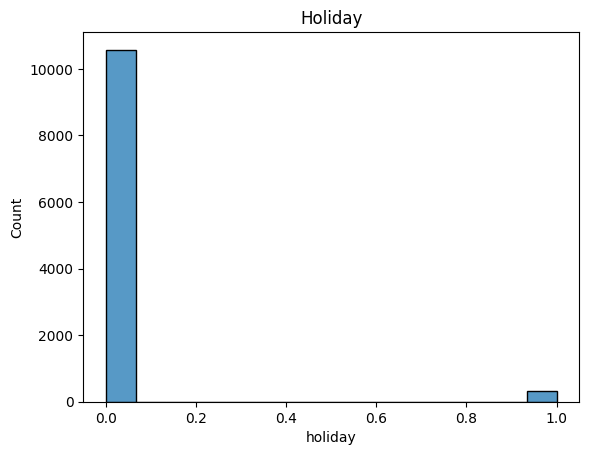

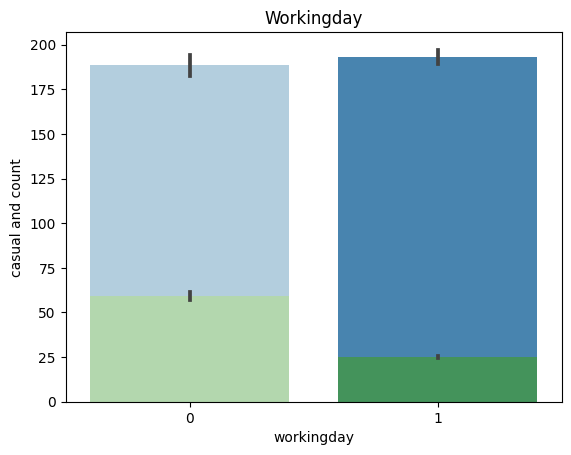

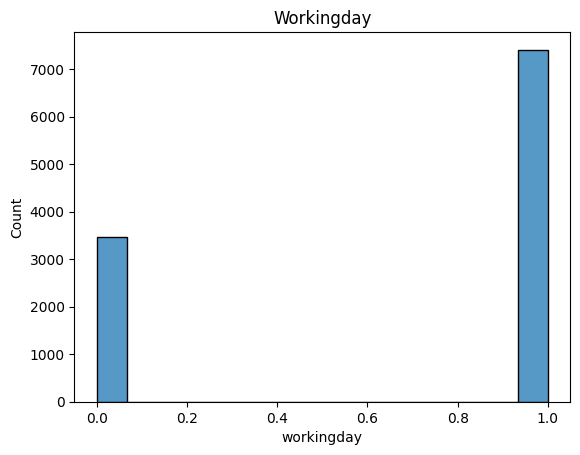

In [22]:
plt.title("Holiday")
sb.barplot(x=train_extended["holiday"], y=train_extended["count"], palette="Blues")
sb.barplot(x=train_extended["holiday"], y=train_extended["casual"], palette="Greens")
plt.ylabel("casual and count")
plt.show()
plt.title("Holiday")
sb.histplot(x=train_extended["holiday"])
plt.show()
plt.title("Workingday")
sb.barplot(x=train_extended["workingday"], y=train_extended["count"], palette="Blues")
sb.barplot(x=train_extended["workingday"], y=train_extended["casual"], palette="Greens")
plt.ylabel("casual and count")
plt.show()
plt.title("Workingday")
sb.histplot(x=train_extended["workingday"])
plt.show()

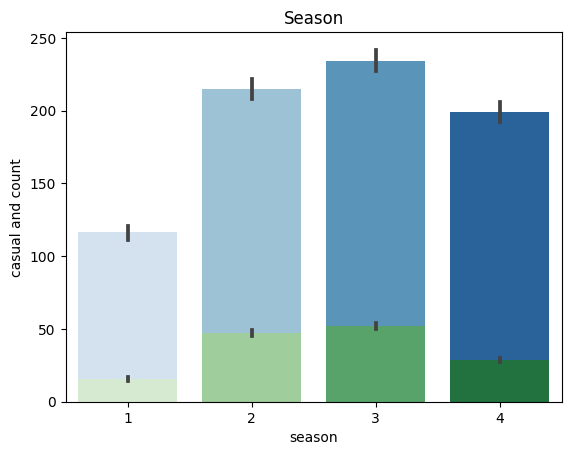

In [24]:
plt.title("Season")
sb.barplot(x=train_extended["season"], y=train_extended["count"], palette="Blues")
sb.barplot(x=train_extended["season"], y=train_extended["casual"], palette="Greens")
plt.ylabel("casual and count")
plt.show()

Wnioski:
- widać trend (roczny)
- widać sezonowość (w zależności od miesiąca liczba wypożyczonych rowerów jest różna)
- zależność od dnia miesiąca zbytnio nie występuje (oraz brakuje danych)
- widać "godzinowość" - zależność od godziny jest znacząca (różnica dystrybucji dla użytkowników registered i casual)
- suma liczby wypożyczeń rowerów w święto/nie święto jest mniej więcej jednakowa, jednakże w roku jest mniej świąt
- suma liczby wypożyczeń rowerów w dzień pracujący/ dzień nie pracujący jest mniej więcej jednakowa, jednakże w roku jest dni niepracujących
- widać różnice w ilości wypożyczonych rowerów dla użytkowników casual oraz registered w zależności od tego czy jest święto lub dzień pracujący
### Badanie zmiennych objaśniających numerycznych

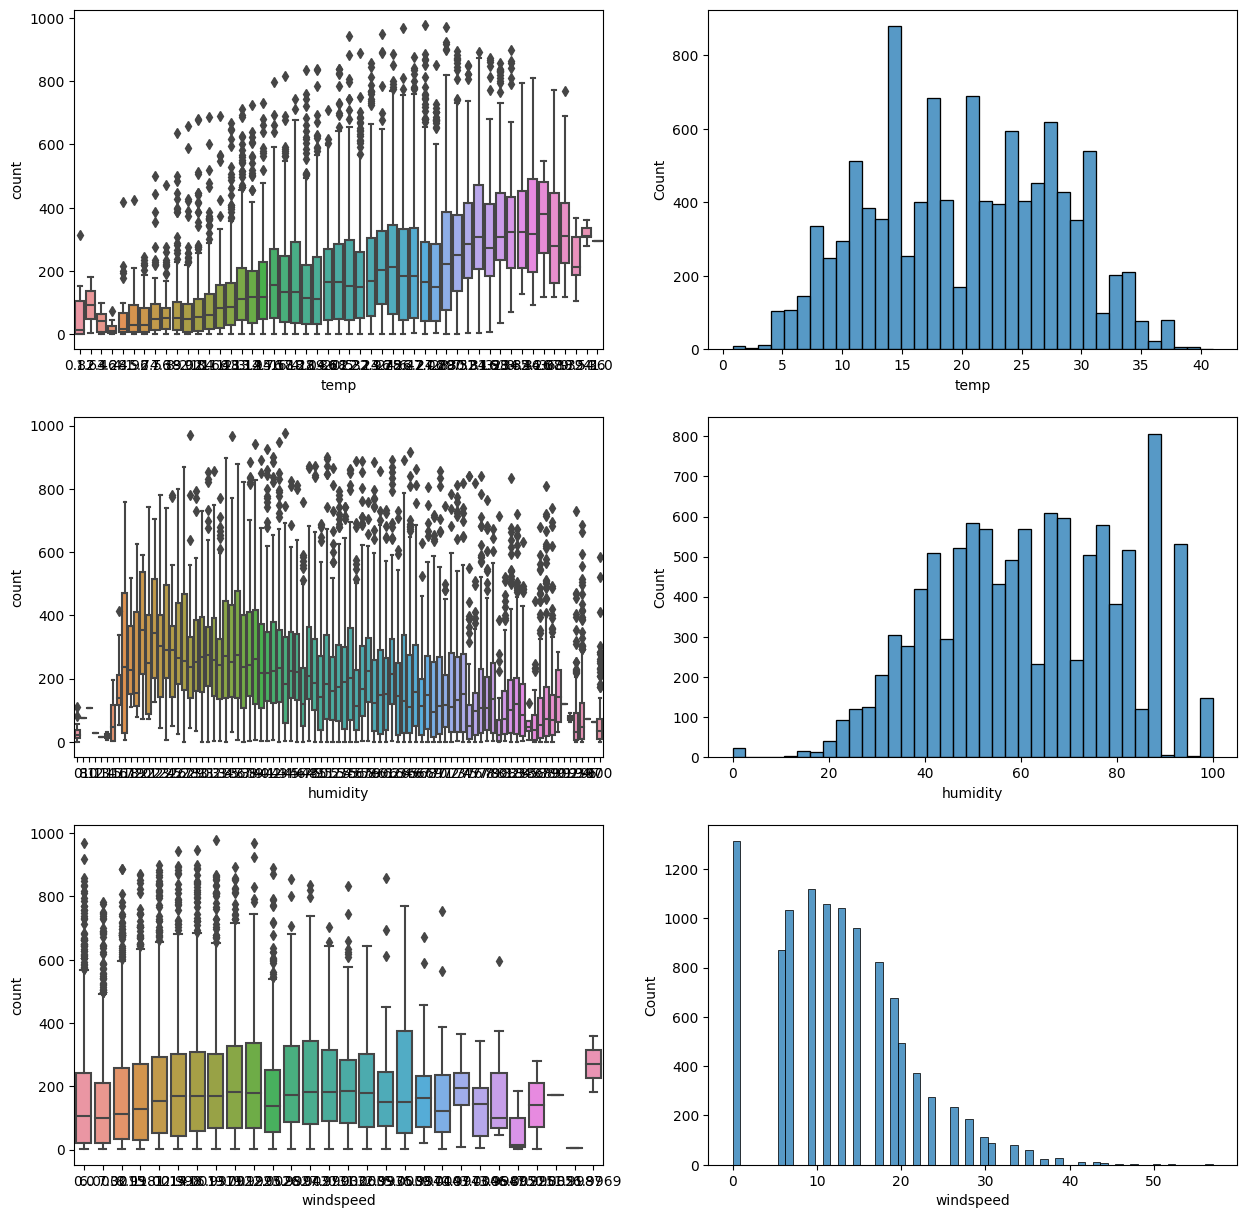

In [63]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
sb.boxplot(x=train_extended["temp"], y=train_extended["count"], ax=axes[0, 0])
sb.histplot(x=train_extended["temp"], ax=axes[0, 1])
sb.boxplot(x=train_extended["humidity"] ,y=train_extended["count"], ax=axes[1, 0])
sb.histplot(x=train_extended["humidity"], ax=axes[1, 1])
sb.boxplot(x=train_extended["windspeed"] ,y=train_extended["count"], ax=axes[2, 0])
sb.histplot(x=train_extended["windspeed"], ax=axes[2, 1])
plt.show()

**Wnioski:**
- temperatura, wilgotność oraz wilgotność mają znaczący wpływ na liczbę wypożyczanych rowerów.
- dla prędkości wiatru występują różnice, jednakże do wartości 40 są one niewielkie, wartości powyżej 40 wahania są większe, jednak te obserwacje należą do klas mniejszościowych
### Badanie zmiennych kategorycznych


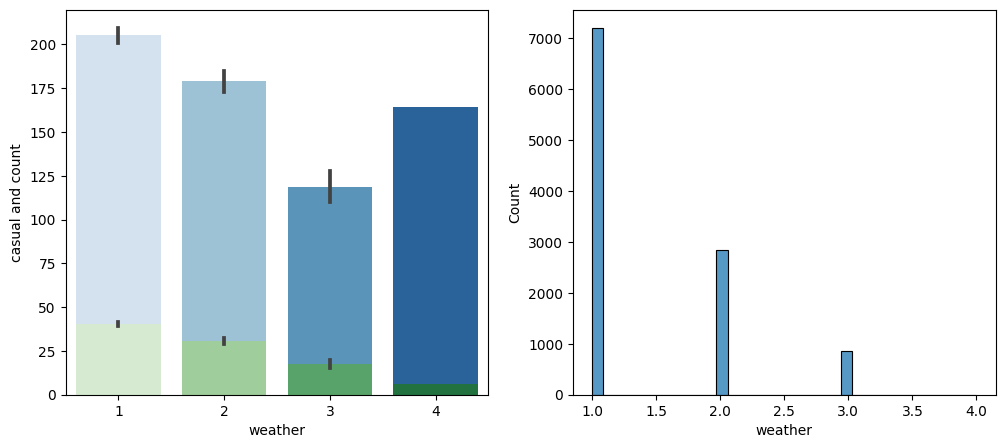

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sb.barplot(x=train_extended["weather"], y=train_extended["count"], palette="Blues", ax=axes[0])
sb.barplot(x=train_extended["weather"], y=train_extended["casual"], palette="Greens", ax=axes[0])
axes[0].set(ylabel="casual and count")
sb.histplot(x=train_extended["weather"], ax=axes[1])
plt.show()

**Wnioski:** Dane są mocno niezbalanoswane, klasa 4 jest prawie niezauważalna. Jednakże, klasa 2 i 4 mają bardzo zbliżoną częstotliwość wypożyczania rowerów (przynajmniej dla wszystkich użytkowników). Przy budowaniu modelu połączymy klasy 2 i 4.

### Badanie korelacji pomiędzy zmiennymi objaśniającymi

In [14]:
sets_concat = pd.concat([train_original, missing_original], join="inner").reset_index(drop=True)

<AxesSubplot:>

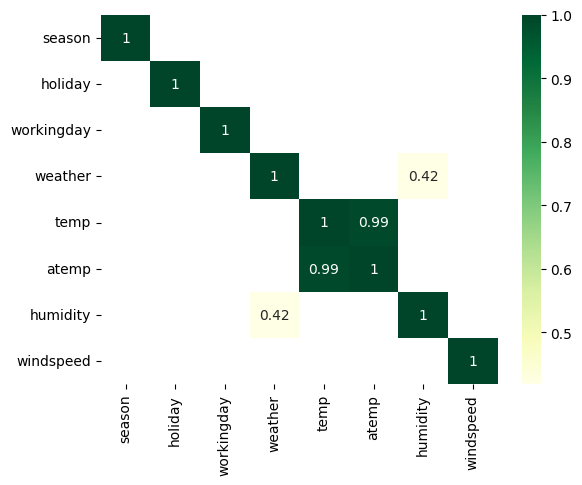

In [15]:
sb.heatmap(sets_concat.corr()[np.abs(sets_concat.corr()) > 0.4], cmap="YlGn", annot=True)

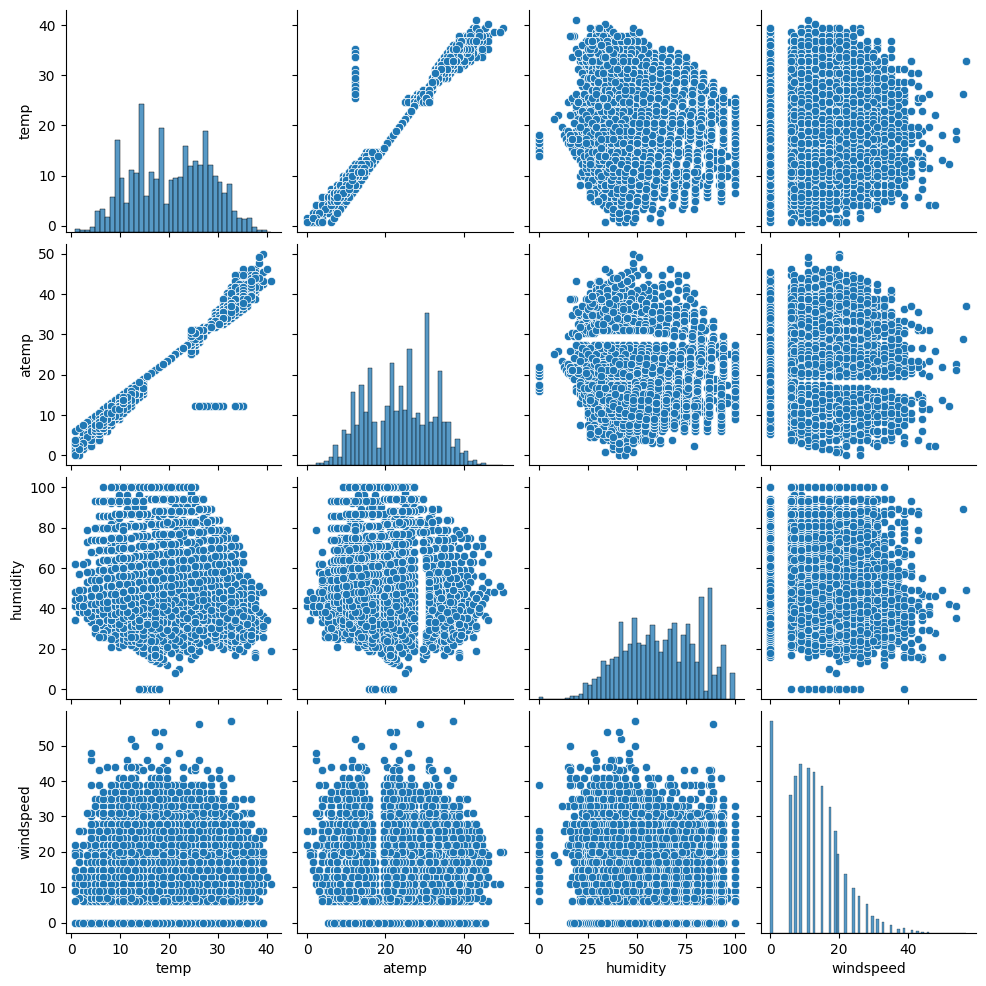

In [57]:
sb.pairplot(sets_concat.drop(columns=["datetime", "season", "holiday", "workingday", "weather"]))
plt.show()

Bardzo mocno skorelowane ze sobą są zmienne *temp* oraz *atemp*. Jedna z nich zostanie usunięta podczas tworzenia modelu predykcyjnego.
Zmienna holiday jest przeciwieństwem zmiennej workingday.

## Podsumowanie
**Zmiennie, które zostaną użyte do predykcji:**
- year
- hour
- season
- workingday
- weather
- temp
- humidity
- windspeed

**Zmiennie, które nie zostaną użyte do predykcji:**
- atemp - zmienna silnie skorelowana ze zmienną temp
- day - mamy niepełne dane (do 20 każdnego miesiąca w train)
- holiday - jest podzbiorem workingday

**Zmienne, do przemyślenia:**
- month - jest w jakiś sposób skorelowana ze zmienną season

**Zmienna predykowa:**
- casual - osobno
- registered - osobno
- counts - jako suma predykcji powyższych